In [1]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import spsolve
import qdldl
from scipy.sparse import block_array
import scipy
from sparse_dot_mkl import dot_product_mkl

In [2]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [3]:
from scipy.stats import Uniform


m = 500000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.01,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 1.*diags_array(np.ones(n))

rng = np.random.default_rng(10)

xx = rng.normal(size = n)
samp = Uniform(a = -0.5,b = 0.5).sample

C = random_array((200,n),
                 density = 0.2,rng = rng)



In [7]:
c = C@xx + 0.01
Q = 1e-7*diags_array(np.ones(n))
f = LogisticNLL(y,w)

In [8]:
def get_step_size(s, ds, y, dy,frac = 0.99):
    """
    Returns stepsize
      s + alpha*ds > 0  and  lam + alpha*dlam > 0
    for all components. with safety factor of frac
    """    
    # For s + alpha*ds > 0  =>  alpha < -s[i] / ds[i] for ds[i] < 0
    idx_s_neg = ds < 0
    if np.any(idx_s_neg):
        alpha_s = np.min(-s[idx_s_neg] / ds[idx_s_neg])
    else:
        alpha_s = np.inf  # If ds >= 0, it doesn't limit alpha
    
    # For y + alpha*dy > 0  =>  y < -y[i] / dy[i] for dy[i] < 0
    idx_y_neg = dy < 0
    if np.any(idx_y_neg):
        alpha_lam = np.min(-y[idx_y_neg] / dy[idx_y_neg])
    else:
        alpha_lam = np.inf
    
    # Final step size is the minimum of those bounds and 1.0 (common practice),
    # possibly multiplied by a safety factor like 0.99 if desired.
    alpha = min(frac*alpha_s, frac*alpha_lam, 1.0)
    return alpha


In [36]:
def solve_glm(f,A,Q,C,c,x0 = None,y0 = None,b = None, lam = 1.):
    """
    Every piece of this is delicate
    in getting good performance. 

    Line search to handle objective is a pain
    """
    max_precenter = 100
    max_iter = 200
    subproblem_tol = 1e-6
    ip_frac = 0.2
    mu_target = 1e-7
    tol = 1e-5
    boundary_frac = 0.98
    gamma = 0.5
    min_mu = 1e-10
    tau_reg =1e-12

    m = A.shape[0]
    n = A.shape[1]
    A = csc_array(A)

    k = C.shape[0]
    print(f"{k} constraints")
    print(f"{n} variables")
    print(f"{m} rows in A")
    assert A.shape[1] == C.shape[1]
    assert C.shape[0] == len(c)

    if x0 is None:
        x = np.zeros(n)
    else:
        x = np.copy(x0)
    
    if y0 is None:
        y = np.ones(k)
    else:
        y = np.copy(y0)
        assert np.min(y)>0
    
    if b is None:
        b = np.zeros(n)
    
    # s = np.ones(k)
    s = np.maximum(c - C@x,0.01)

    def KKT_res(x,g,y,s,mu):
        rx = C.T@y - b + g
        rp = C@x + s - c
        rc = y * s - mu*np.ones(k)
        return rx,rp,rc
    
    Ik = diags_array(np.ones(k))   
    In = diags_array(np.ones(n))     
    def solve_KKT(x,y,s,H,rx,rp,rc,mu,solver = None):
        #Nesterov-Todd scaling
        # Quasi definite for inequality constraints, 
        # "normal equations" Hessian for GLM part
        w = np.sqrt(y/s)
        wC = C.multiply(w[:,None])
        G = block_array(
            [
                [H+tau_reg*In,wC.T],
                [wC,-Ik]
            ],format = 'csc'
        )
        rhs = np.hstack([-rx,-w*rp + (w/y) * rc])
        if solver is None:
            solver = qdldl.Solver(G)
        else:
            solver.update(G)
        sol = solver.solve(rhs)
        # linres = rhs - G@sol
        dx = sol[:n]
        dy = w*sol[n:]
        ds = -rp - C@dx
        return dx,ds,dy,solver
    
    def get_H(z):
        D = f.d2f(z)[:,None]
        # return A.T@A.multiply(D) + Q
        # use dot_product_mkl
        AtDa = dot_product_mkl(A.T,csc_array(A.multiply(D)))
        # return A.T@A.multiply(D) + Q
        return AtDa + Q
        

    
    #Phase 1 to obtain feasibility
    # simple QP acts a precentering step
    z = A@x
    Hf = get_H(z)

    gradf = A.T@f.d1f(z)
    H = 0.001*np.mean(Hf.diagonal())*diags_array(np.ones(n)) + Hf

    mu = 10.
    solver = None

    #Add initialization info here:



    #______________________________

    for i in range(max_precenter):
        #Gradient of the objective (without the b tilt)
        g = H@x + gradf
        rx,rp,rc = KKT_res(x,g,y,s,mu)
        kkt_res = np.max(
            np.abs(np.hstack([rx,rp,rc]))
        )
        primal_violation = np.max(np.abs(rp))
        print("Primal violation", primal_violation)
        print("Max KKT res:", kkt_res)
        print("Inequality violation:",np.min(c - C@x))
        print("New mu:",mu)
        print("______________________________")

        if (
            primal_violation<=1e-4 and 
            kkt_res<=1000 and
            (C@x + 1e-7<= c).all()
        ):
            break
        dx,ds,dy,solver = solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
        t = get_step_size(s,ds,y,dy,frac = boundary_frac)
        x = x + t*dx
        s = s + t*ds
        y = y + t*dy
    print(f"Finished centering in {i} iterations")
    
    def merit_line(t,x,dx,mu):
        xt = x+t*dx
        return f(A@xt) + (1/2) * xt.T@Q@xt#-mu*np.sum(np.log(c - C@(x+t*dx)))

    #Phase 2 to fit model
    for i in range(max_iter):
        print("______________________________")
        print(f"Iteration {i}")
        z = A@x
        H = get_H(z)
        gradf = A.T@f.d1f(z) + Q@x
        rx,rp,rc = KKT_res(x,gradf,y,s,mu)
        kkt_res = np.max(
            np.abs(np.hstack([rx,rp,rc+ mu*np.ones(k)]))
        )
        print("mu,KKTres", mu,kkt_res)
        if kkt_res<=tol:
            break
        
        dx,ds,dy,solver = solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
        tmax = get_step_size(s,ds,y,dy,frac = boundary_frac)
        m0 = merit_line(0.,x,dx,mu)
        t = tmax
        for i in range(10):
            mt = merit_line(t,x,dx,mu)
            if mt<m0:
                break
            else:
                t = 0.9*t
        print("t,merit_dec",t,mt - m0)
        x = x + t*dx
        s = s + t*ds
        y = y + t*dy

        if kkt_res<=100 * mu+1e-4:
            mu_est = np.dot(s,y)/k
            xi = np.min(s*y)/mu_est
            mu = np.maximum(np.maximum(mu*0.01,min_mu),gamma * np.minimum(
                (1-boundary_frac)*(1-xi)/xi + 0.1,2
            )**3 * mu_est)
            print("(1-xi)/xi = ",(1-xi)/xi)
            print("xi",xi)
            print("min term", np.minimum(
                (1-boundary_frac)*(1-xi)/xi,2
            ))

    return x


In [37]:
x = solve_glm(f,A,Q,C,c)

200 constraints
500 variables
500000 rows in A
Primal violation 16.54245139960916
Max KKT res: 10566.31267677416
Inequality violation: -16.532451399609158
New mu: 10.0
______________________________
Primal violation 16.50430670841483
Max KKT res: 10541.948166074868
Inequality violation: -16.49841426113423
New mu: 10.0
______________________________
Primal violation 16.433461487976615
Max KKT res: 10496.69654449097
Inequality violation: -16.432306573540636
New mu: 10.0
______________________________
Primal violation 16.296847733594884
Max KKT res: 10409.435980148039
Inequality violation: -16.291699867190665
New mu: 10.0
______________________________
Primal violation 15.787177950021366
Max KKT res: 10083.889894803691
Inequality violation: -15.785482316223671
New mu: 10.0
______________________________
Primal violation 14.585116587629306
Max KKT res: 9316.08614523344
Inequality violation: -14.580194391195887
New mu: 10.0
______________________________
Primal violation 10.69365785418918
M

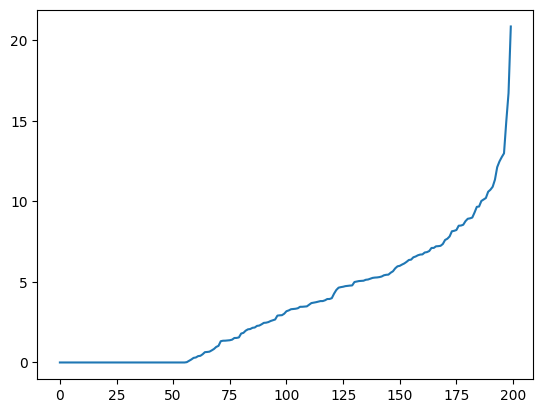

In [35]:
plt.plot(np.sort(c - C@x))

In [23]:
import cvxpy as cp
n = A.shape[1]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
neg_log_likelihood = cp.sum(
    cp.multiply(w,cp.logistic(A @ beta)- cp.multiply(y, A @ beta))
)
regularization = beta.T@Q@beta/2

problem  = cp.Problem(cp.Minimize(
    (neg_log_likelihood + regularization)),[C @ beta <= c]
)
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 16 11:49:56 PM: Your problem has 500 variables, 200 constraints, and 0 parameters.
(CVXPY) Apr 16 11:49:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 16 11:49:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 16 11:49:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 16 11:49:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 16 11:49:56 PM: Compiling problem (target solver=CLARABEL

3505019.0029566674

In [15]:
print(f(A@x) + (1/2) *x.T@Q@x)

cvx_x = beta.value
print(f(A@cvx_x) + (1/2) *cvx_x.T@Q@cvx_x)

3505019.0029590246
3505019.0029566674


In [16]:
cvx_x - x

array([ 3.40149817e-07,  4.90253315e-08,  3.04835206e-07,  1.47093488e-07,
        3.48785357e-07,  5.22443372e-08,  6.50401118e-07, -1.40680298e-06,
        1.47155989e-07,  9.70969931e-08, -5.44483909e-07, -2.62138820e-07,
       -2.30468384e-07, -1.17885728e-06, -4.36991611e-07,  4.07839497e-07,
        6.64217602e-07,  7.17968638e-08,  3.08286648e-07, -8.55348345e-07,
        3.48855312e-07, -3.73906880e-07, -6.31572077e-08, -2.85713063e-07,
        1.32431527e-08,  4.42560003e-07,  1.07083628e-07,  1.82429938e-08,
       -2.06376481e-07,  4.84264727e-07,  5.17951059e-08,  6.77992427e-07,
        8.74599706e-07, -2.22494313e-07, -1.85992268e-07,  1.58281212e-07,
        4.32800805e-07,  3.37504200e-07, -2.89015493e-08, -1.08736767e-07,
       -3.18852289e-07, -2.55658808e-07,  1.39896230e-06, -2.96472676e-08,
       -1.92413575e-07, -3.83607060e-07,  6.25328567e-07, -2.37863369e-07,
        8.64719368e-07,  4.90255074e-07,  1.06773801e-06,  6.98791660e-07,
        2.08768484e-07,  

In [177]:
print(problem.value -f(A@x) - (1/2) *x.T@Q@x)

-6.8239253430135705e-06
